In this individual assignment we will take a look at sentiment analysis task with Naive Bayes classifier.

---

Assignment consists of 3 parts:


*   Data exploration
*   Sentiment classification
*   Report


You can use the following references as a guide for your homework:

* https://www.enjoyalgorithms.com/blog/sentiment-analysis-using-naive-bayes
* https://www.enjoyalgorithms.com/blog/text-data-pre-processing-techniques-in-ml
* https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes
* For precision, recall, f1 refer to https://scikit-learn.org/stable/modules/classes.html?highlight=metrics#module-sklearn.metrics

To access dataset:

Option 1: upload data to your Google Drive, then mount the drive

Option 2: upload directly to colab


In [ ]:
# To mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First let's import all neccessary for this assignment modules.

In [ ]:
!pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import scattertext as st
import spacy
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import WhitespaceTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

Now, pick a dataset for the analysis from the following:


*   Financial dataset (https://www.kaggle.com/datasets/sbhatti/financial-sentiment-analysis)
*   Movie review (https://www.kaggle.com/code/lakshmi25npathi/sentiment-analysis-of-imdb-movie-reviews/data)
* Amazon Kindle Book Review (https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis) - use 'preprocessed_kindle_review.csv and convert rating into sentiment: 1-2: negative, 3: neutral, 4-5: positive
* Steam Reviews (https://www.kaggle.com/datasets/piyushagni5/sentiment-analysis-for-steam-reviews) use train.csv and treat 'user_suggestion' as a Sentiment 1-positive, 0-negative

Download it from kaggle.com and upload to this colab: left menu 'Files'-> 'Upload file'

**Make sure that your file is fully uploaded before proceeding**


# Data Exploration

In [ ]:
# Use pd.read_csv to upload dataset [~ 1 line].
# You can use 'usecols' argument to specify which columns to load


# Your code here:
dataset = pd.read_csv("/content/drive/MyDrive/data/data.csv")

In [ ]:
# You can take a look at first 5 entries with the following
dataset.head(5)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
# If you don't have an explicit 'sentiment' column, 
# identify which can be used as a proxy and create a 'sentiment' column based on
# the proxy column. 


# Your code here:
# Hint: use '.map' method
dataset['label'] = dataset['Sentiment'].map({"positive":2, "negative":1, "neutral":0})
dataset.head(5)


,Sentence,Sentiment,label
0,The GeoSolutions technology will leverage Bene...,positive,2
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,1
2,"For the last quarter of 2010 , Componenta 's n...",positive,2
3,According to the Finnish-Russian Chamber of Co...,neutral,0
4,The Swedish buyout firm has sold its remaining...,neutral,0


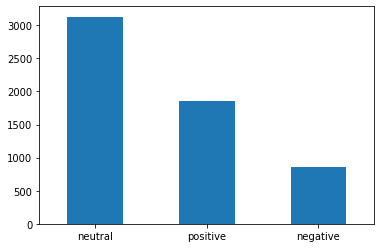

In [ ]:
# Now let's take a look at the distribution of labels (i.e. sentiment values)
# across the dataset.

# Display a bar plot based on value counts of the 'sentiment' column [~ 1 line] 

# Your code here:
dataset['Sentiment'].value_counts().plot(kind='bar',rot=0)

**Answer this question in your report:**

What problem we see with the dataset, if any?

If there is a problem, how it can impact classification?

In [ ]:
# Let's create a separate numerical column 'label', 
# which will be used by our classifier.

# Create a new column 'label' based on values in the 'sentiment' column.
# It is up to you what number to assign to each category. [~ 1 line]
# For example, if there are 3 categories ("positive", "negative", "neutral"),
# I would use something like:
# 
# >>> df[<your sentiment column>].map({"positive":2, "negative":1, "neutral":0})


# Your code here:
dataset['label'] = dataset['Sentiment'].map({"positive":2, "negative":1,"neutral":0})


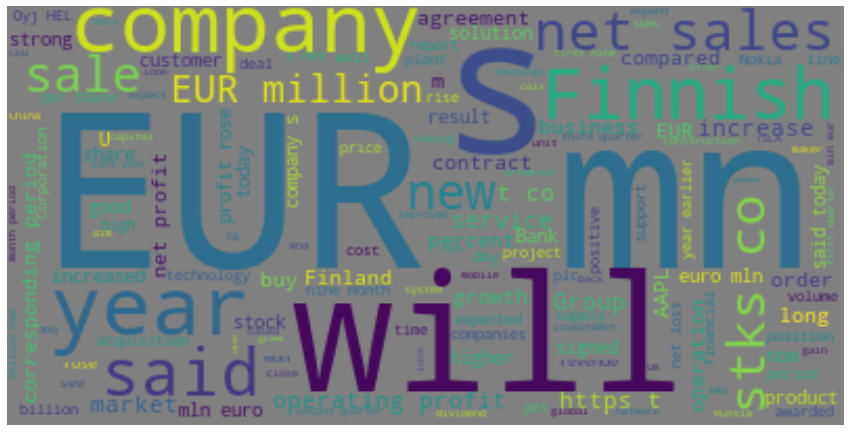

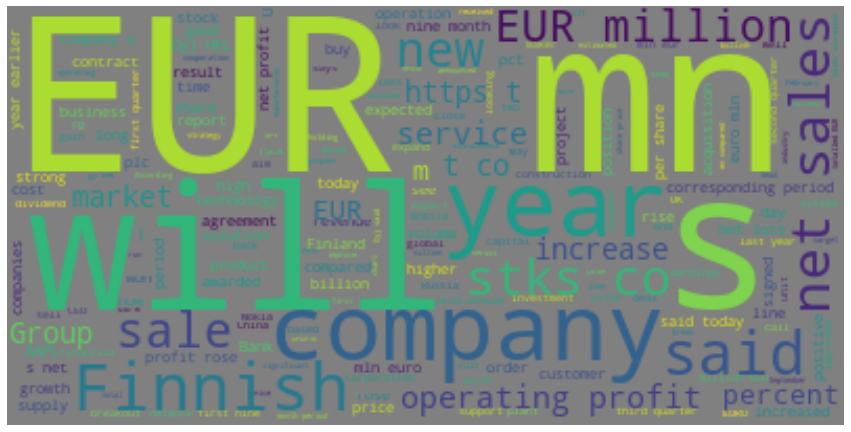

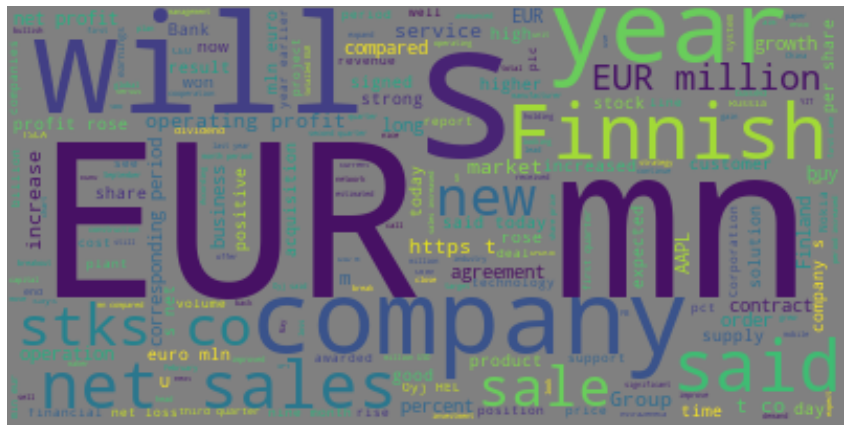

In [ ]:
# To further get a notion of our dataset, let's display 
# a word cloud for each sentiment category, present in your dataset. [~ 7 lines per category]

# You are free to use the following code as a general guide.

# First let's extract only positive sentences
# >>> positive = dataset[dataset[<sentiment column>] == "positive"]
# Now let's write all positive entries into one variable
# >>> text = "".join([i for i in positive[<sentence column>]])
# The following creates a WordCloud instance
# >>> wordcloud = WordCloud(background_color="grey").generate(text)
# Finally, let's display our word cloud
# >>> plt.figure(figsize=(15,10))
# >>> plt.imshow(wordcloud, interpolation='bilinear')
# >>> plt.axis("off")
# >>> plt.show()

# Your code here:
positive= dataset[dataset['Sentiment'] == "positive"]
text = "".join([i for i in positive["Sentence"]])
wordcloud = WordCloud(background_color="grey").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

negative = dataset[dataset['Sentiment'] == "negative"]
text = "".join([i for i in positive["Sentence"]])
wordcloud = WordCloud(background_color="grey").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

neutral = dataset[dataset['Sentiment'] == "neutral"]
text = "".join([i for i in positive["Sentence"]])
wordcloud = WordCloud(background_color="grey").generate(text)
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# For a more interactive exploration of your dataset, 
# we will use 'scattertext' library, imported as st

# Adjust the following code to work with your dataset
# Leave this line as is
nlp = spacy.load('en_core_web_sm')

# Now let's remove stopwords
nltk.download('stopwords')
stpwrds = stopwords.words('english')

# Let's exclude neutral sentences, if there are any
# Use the following example as a reference:
# >>> ds = dataset[dataset["sentiment"] != "neutral"].copy()
ds = dataset[dataset["Sentiment"] != "neutral"].copy()

# The following code puts your sentences into lower case and removes stopwords
# Change '<Your Sentences Column>' to the name of the column with sentences.
ds['Sentence'] = ds['Sentence'].apply(lambda words: ' '.join(
        str(word).lower() for word in words.split() 
        if str(word).lower() not in stpwrds)
    )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from textblob.blob import Sentence
from textblob.en import Sentiment
# Let's create a corpus for the following plot.
# It is possible, that this will take a long time, 
# when the whole ds is provided. In this case, pick a slice of your dataset,
# i.e. ds[:1000], or ds[2000:3500], etc.
corpus = st.CorpusFromPandas(ds,
                             category_col= 'Sentiment' , # provide the name of your sentiment column here
                             text_col= 'Sentence', # provide the name of your sentences' column here
                             nlp=nlp).build()

In [ ]:
# The following code will create an interactive plot and save it as 'my_plot.html'.
# Download it to your machine and open in a separate tab to explore.
# Include a screenshot in your report. 
html = st.produce_scattertext_explorer(
    corpus,
    category="negative",
    not_category_name="positive",
    transform=st.Scalers.log_scale_standardize
)
open('./my_plot.html', 'wb').write(html.encode('utf-8'))

/usr/local/lib/python3.7/dist-packages/scattertext/ScatterChart.py:441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(np.round).astype(int))
/usr/local/lib/python3.7/dist-packages/scattertext/ScatterChart.py:444: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  .apply(np.round).astype(int))
/usr/local/lib/python3.7/dist-packages/scattertext/ScatterChart.py:451: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

889285

# Sentiment classification

In [ ]:
# Let's preprocess dataset first
# First, put your sentences in a lowercase [~ 1 line]
# Suggestion: create a separate variable (e.g. corpus)
# to store sentences from the dataset

# Your code here
corpus = ds['Sentence'].str.lower()
corpus.head(5)

0    geosolutions technology leverage benefon 's gp...
1           $esi lows, $1.50 $2.50 bk real possibility
2    last quarter 2010 , componenta 's net sales do...
5                       $spy surprised see green close
6    shell's $70 billion bg deal meets shareholder ...
Name: Sentence, dtype: object

In [ ]:
# Now, let's replace hyperlinks, if any exist [~ 1line]
# Hint: regex for hyperlinks is r"http\S+"

# Your code here
corpus = corpus.str.replace(r"http\S+", "", regex=True)

In [ ]:
# Finally, let's remove punctuations
# Hint: regex for punctuations r"[^A-Za-z0-9]+"

# Your code here
corpus = corpus.str.replace('[^A-Za-z0-9]+',' ', regex=True)
#corpus.head(5)

In [ ]:
# Now let's remove stopwords
nltk.download('stopwords')
stpwrds = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from numpy import dtype
# Remove stopwords from the text [~ 1 line]

# Your code here:
corpus = corpus.apply(lambda words: ' '.join(word.lower() for word in words.split() if word not in stpwrds))
#corpus.head(5)

In [ ]:
from scattertext.TermDocMatrixFromPandas import CorpusFactoryHelper
# Lemmatization
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


# Create an instance of a WhitespaceTokenizer [1 line],
# and WordNetLemmatizer [1 line]
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
# Perform lemmatization on your sentences,
# for example, if my sentence array is stored 
# in a corpus variable, I would use the following code:
# >>> corpus = corpus.apply(
# >>>    lambda words: ' '.join(
# >>>        lemmatizer.lemmatize(word) for word in tokenizer.tokenize(words)
# >>>        )
# >>>    )

# Your code here:
corpus = corpus.apply(
    lambda words: ' '.join(
        lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(words)
    )
)



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# Create an instance of a CountVectorizer [1 line]
# and encode your sentences [~ 1 line]
# hint: look into fit_transform

# Your code here:
count_vectorizer = CountVectorizer(stop_words=stpwrds, max_features= 1000)
x = count_vectorizer.fit_transform(corpus)



In [ ]:
# Create a separate variable, which holds a numpy array of labels [1 line]
# Hint: use to_numpy()

# Your code here:
array_1 = ds['label'].to_numpy()

In [ ]:
# Create a train and test dataset with 'train_test_split' [1 line]

# Your code here:
X_train, X_test, y_train, y_test = train_test_split(x, array_1, test_size=0.4, train_size= 0.6, random_state=5, shuffle = True, stratify=None)


In [ ]:
# Create an instance of a MultinomialNB model [1 line]
# and fit it with a training data [1 line]

# Your code here:
m_inst = MultinomialNB()
m_inst.fit(X_train, y_train)


MultinomialNB()

In [ ]:
# Evaluate your model on a test dataset [~ 1 line]
# Hint: display the accuracy, achieved on a test data

# Your code here 
m_inst.score(X_test,y_test, sample_weight=None)*100

79.17050691244239

In [ ]:
mn_predict = m_inst.predict(X_test)

In [ ]:
# Create an instance of a ComplementNB model [1 line]
# and fit it with a training data [1 line] 

# Your code here:
CNB_model = ComplementNB()
CNB_model.fit(X_train,y_train)

ComplementNB()

In [ ]:
cnb_predict = CNB_model.predict(X_test)

In [ ]:
# Evaluate your model on a test dataset [~ 1 line]
# Hint: display the accuracy, achieved on a test data

# Your code here:
CNB_model.score(X_test,y_test, sample_weight=None)*100



76.6820276497696

In [ ]:
from nltk.metrics.scores import recall
# For both models calculate precision, recall and F1 scores [~ 8 lines]
# Your code here:
mnb_precision = precision_score(y_test,mn_predict)
cnb_precision = precision_score(y_test,cnb_predict)
mnb_recall = recall_score(y_test,mn_predict)
cnb_recall = recall_score(y_test,mn_predict)
mnb_f1 = f1_score(y_test, mn_predict)
cnb_f1 = f1_score(y_test,mn_predict)

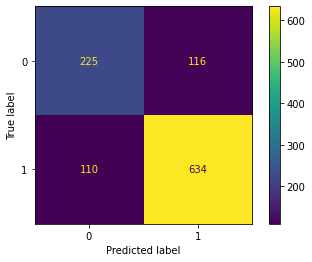

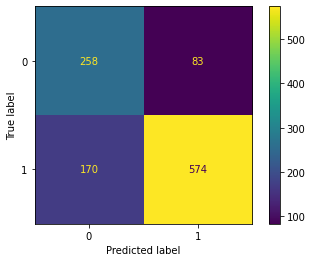

In [ ]:
# For both models display confusion matrix [~ 6 lines]
# Hint: metrics.confusion_matrix can be used to calculate the matrix
# and metrics.ConfusionMatrixDisplay can be used for plotting

# Your code here:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

mnb_mat = confusion_matrix(y_test, mn_predict)
cnb_mat = confusion_matrix(y_test, cnb_predict)
mnb_mat_disp = ConfusionMatrixDisplay(confusion_matrix = mnb_mat, display_labels= None)
cnb_mat_disp = ConfusionMatrixDisplay(confusion_matrix = cnb_mat, display_labels= None)
mnb_mat_disp.plot()
plt.show()
cnb_mat_disp.plot()
plt.show()



# Report

In [ ]:
# Finally, compose a report, which will include your thoughts on the data you've explored:
# Include all plots, you've generated accompanied with your analysis.
# Include analysis of 2 classifiers you've used in this analysis. Which of them was better and why?
# Again, include calculated scores and plots, accompanied with your analysis.


CS 670 : ARTIFICIAL INTELLIGENCE
1.	DATA EXPLORATION :
The chosen dataset for the classifier algorithms was a financial dataset intended for advancing financial sentiment analysis research.

The given dataset consisted of two data columns – Sentence & Sentiment, of which the Sentence column consisted of textual data and the Sentiment column consisted of sentiments (positive, negative, and neutral) for the given texts.

In the procedure of data exploration, first the .csv file of the data is downloaded on a drive and then read and stored in a variable. Furthermore, the first few rows have been displayed to check whether the loaded data is correct or not.

Next, a bar plot of the data is displayed based on the value counts of ‘Sentiment’ column.

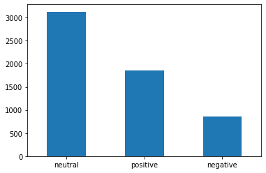
 
Then, a proxy column named ‘label’ is added to the dataset and the positive, negative and neutral sentiments are mapped in the column as 2,1 and 0 respectively.

After this, a word cloud is displayed for each sentiment category in the dataset.


 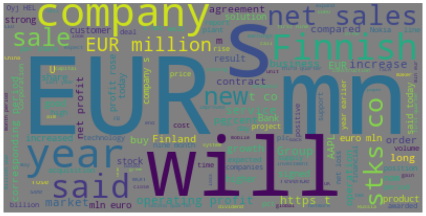
Word Cloud - Positive Sentiment 

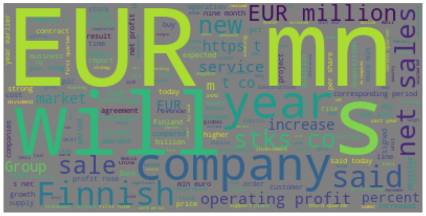 
Word Cloud - Negative Sentiment 

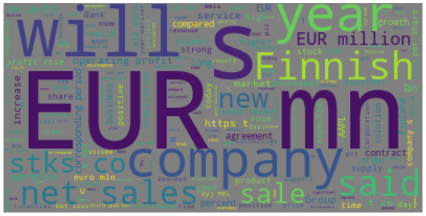 
Word Cloud - Neutral Sentiment 

Next, we take all the neutral sentences from the dataset and store them in a new variable ‘ds’ and remove the stop words and turn the text in the new dataset into lowercase.

After that, we create a corpus that contains text data that will be used to train our model and then produce an interactive plot for this.

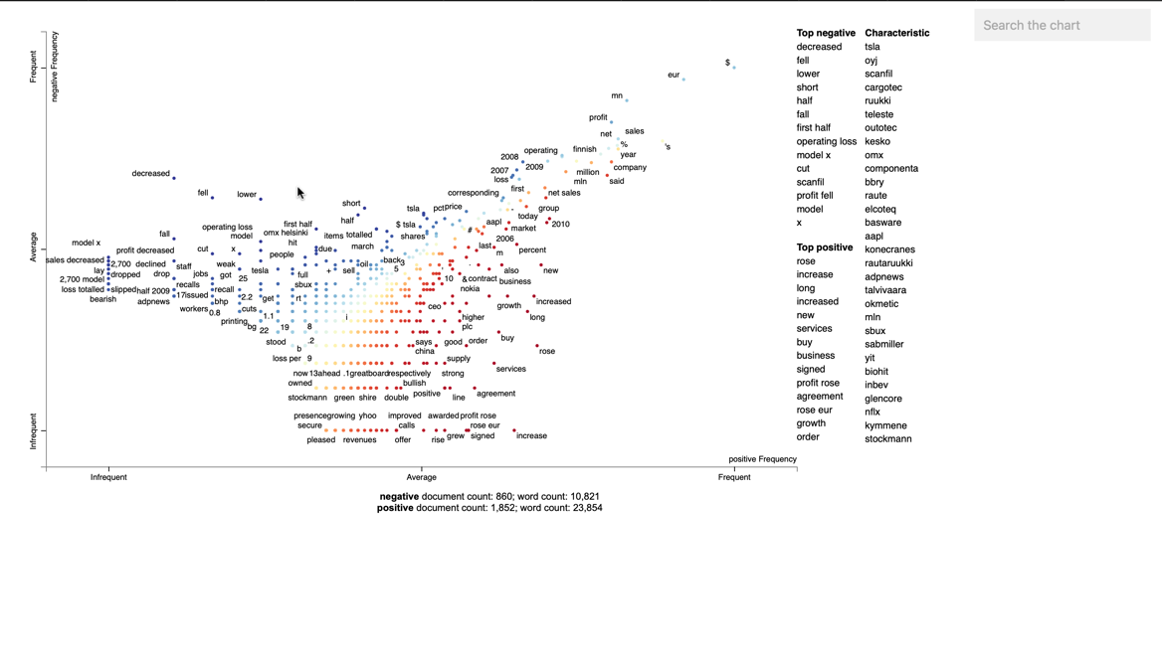 
my_plot.html 
2.	SENTIMENT ANALYSIS :
For the Sentiment Analysis, we first store the dataset into a separate variable (‘corpus’) to pre-process and operate on so that our code does not affect the original dataset. We then put all the sentences in the corpus to lowercase and remove all the hyperlinks, punctuations and stopwords from it.

Secondly, we perform lemmatization on the sentences to convert and group together words based on their base forms. Then, we create an instance of CountVectorizer to turn the text into vector format on the basis of frequency count of each word appearing in the sentence.

We then use fit_transform to encode the sentences and scale the training data and then initialize a numpy array to store the labels.

The data is then split into training and test data using the train_test_split method which splits the data into subsets to minimize the bias for the evaluation and validation process.

A.	Multinomial Naïve Bayes model :
Here, we create an instance of Multinomial Naïve Bayes model which considers a feature vector where a given number represents the number of times it appears based on its frequency and fit it with our training data.

Then we test the accuracy of our model on our the created instance using the .score function.(accuracy - 79.17050691244239)
	
B.	Complement Naïve Bayes model :
As above, we create an instance of Complement Naïve Bayes model which considers a feature vector where a given number represents the number of times it appears based on its frequency and fit it with our training data.(accuracy - 76.6820276497696)

Then we test the accuracy of our model on the created instance using the .score function.

Meanwhile, two variables ‘mn_predict’ and ‘cnb_predict’ are created to store the predicted values of test models that’ll further used for analysis.

Lastly, for both the models we calculate the precision (The ratio of correctly predicted observations to the total predicted observations), recall(The ratio of correctly predicted observations to all the observations in actual class) and F1 score(Weighted average of Precision and Recall) for both the models. And then, the confusion matrix of both the models are plotted to show the accuracy and performance of the models.

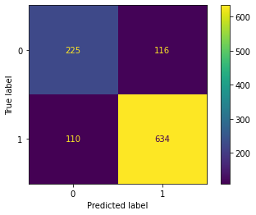 
Confusion matrix - MultinomialNB model 


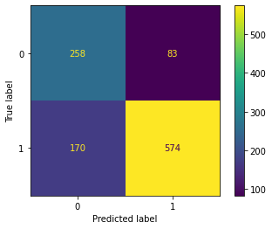
Confusion matrix - ComplementlNB model 
3.	CONCLUSION :
In conclusion, I would go for the Multinomial Naïve Bayes algorithm rather than the Complement Naïve Bayes algorithm as it provides better accuracy for the given dataset and it suits best for discrete values of dataset such as word counts whereas Complement Naïve Bayes counts the occurrences of a word in the complement to the class.


---

